# Random Forest Model

RF is one of the models we applied to predict deaths for COVID-patients in Mexico.
It is worth noting that the data is highly imbalanced, and Random Forest doesn't work well with imbalanced data because it aims to minimize the overall error rate, rather than paying special attention to the positive class.
To alleviate the problem, we follow two proposed models by [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf): balanced random forest (BRF) and weighted random forest (WRF).

In [1]:
import pre_ml
%load_ext autoreload
%autoreload 2
import mlpipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix

In [2]:
df = pre_ml.data(False)
df.head(10)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory


,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,...,obesidad,tabaquismo,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras,hospitalizado,muertos,covid_grave
0,5,14,5014,0.0,92,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,68.7,4.995184,2.383058,10.741822,27.221458,1,1,1
1,9,7,9007,0.0,35,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.4,16028.524764,2.170140,7.325600,17.785234,0,0,0
2,30,193,30193,0.0,50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.3,2537.821317,4.131322,16.110560,42.158624,0,0,0
3,9,14,9014,0.0,62,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,3.2,16243.745318,6.156216,28.636779,83.143497,0,0,0
4,9,17,9017,0.0,52,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27.7,12794.772593,2.400567,7.478689,18.419735,0,0,0
5,15,33,15033,0.0,44,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,37.6,10709.607425,1.147706,4.807484,14.258494,0,0,0
6,19,26,19026,0.0,23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,19.1,6036.307248,0.619358,5.489764,16.131462,0,0,0
7,25,6,25006,0.0,67,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,31.2,152.715706,2.637944,10.489463,30.502528,1,0,1
8,7,108,7108,0.0,61,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,82.3,60.845487,4.062546,5.186229,23.510904,1,0,1
9,2,4,2004,0.0,64,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,31.1,1449.318075,0.726447,4.889549,11.701390,1,0,1


## 1. Pre-process

### 1.1 Split data and define features/target variables

In [3]:
#1st Step: Split
train, test = mlpipeline.split_data(df, test_size=0.2, seed=0)
print('Training data observations:{}'.format(train.shape[0]))
print('Testing data observations:{}'.format(test.shape[0]))
print('Training observations of Deaths=1 and no Deaths=0')
print(train['muertos'].value_counts())

Training data observations:72531
Testing data observations:18133
Training observations of Deaths=1 and no Deaths=0
0    64569
1     7962
Name: muertos, dtype: int64


_As seen in the data, only 11% corresponds to one label. When doing Cross Validation, some samples may not have the label = 1 in their data. So, we must take into account some balance techniques._

In [4]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target = ['muertos']

## 2. Model Learning and Evaluation: Random Forest

### 2.2 Balanced Random Forest Classifier
From [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf), 
the BRF algorithm works as follows:  
1. For each iteration in random forest, draw a bootstrap sample from the minority class. Randomly draw the same number of cases, with replacement, from the majority class.
2. Induce a classification tree from the data to maximum size, without pruning. The tree is induced with the CART algorithm, with the following modification: At each node, instead of searching through all variables for the optimal split, only search through a set of m randomly selected variables.
3. Repeat the two steps above for the number of times desired. Aggregate the predictions of the ensemble and make the final prediction.

In [42]:
from sklearn.model_selection import GridSearchCV
params = {'criterion':['gini', 'entropy'], 'max_depth':[5,10, 15],
         'min_samples_split':[10, 15]}       
grid_brf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=0), 
                          param_grid=params, 
                          cv=10,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')

#### 2.2.1 Target: Death

In [43]:
grid_brf_d =grid_brf
grid_brf_d.fit(train[features],train[target].values.ravel())
brf_results = pd.DataFrame(grid_brf_d.cv_results_)

In [44]:
pd.set_option('mode.chained_assignment', None)
cols_to_keep = ['param_criterion','param_max_depth', 'param_min_samples_split',
                'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
brf_results = brf_results[cols_to_keep]
brf_results.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
6,entropy,5,10,1,0.813868,0.820941,0.214767,0.216613
7,entropy,5,15,2,0.813367,0.820676,0.214531,0.216262
1,gini,5,15,3,0.810980,0.816015,0.216335,0.217644
0,gini,5,10,4,0.810728,0.816168,0.216627,0.217814
3,gini,10,15,5,0.806334,0.830863,0.226278,0.233385
8,entropy,10,10,6,0.804701,0.833110,0.225388,0.233322
2,gini,10,10,7,0.801812,0.832370,0.225619,0.234175
9,entropy,10,15,8,0.801560,0.829928,0.225546,0.233279
11,entropy,15,15,9,0.796788,0.851447,0.228968,0.244882
5,gini,15,15,10,0.795155,0.852494,0.229276,0.246004


Best Balanced Random Forest Model to predict Death: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Model's Accuracy on test data: 0.65
Model's Precision on test data: 0.21
Model's Recall on test data: 0.82
Model's F1 Score: 0.336


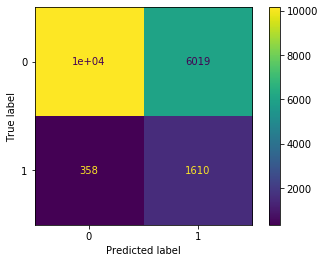

In [45]:
print('Best Balanced Random Forest Model to predict Death: {}'.format(grid_brf_d.best_params_))
mlpipeline.confusion_metrics(grid_brf_d.best_estimator_, test, features, target)

#### 2.2.1 Target: Hospitalization

In [46]:
target2 = 'hospitalizado'

In [47]:
#Train the model with hospitalizado
grid_brf_h = grid_brf
grid_brf_h.fit(train[features], train[target2])
#Store the results
brf_results_hos = pd.DataFrame(grid_brf_h.cv_results_)
brf_results_hos = brf_results_hos[cols_to_keep]
brf_results_hos.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results_hos.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
11,entropy,15,15,1,0.719387,0.761163,0.567478,0.602252
4,gini,15,10,2,0.719190,0.766611,0.567635,0.608725
9,entropy,10,15,3,0.718756,0.733417,0.562204,0.574580
5,gini,15,15,4,0.718638,0.762617,0.567160,0.603956
10,entropy,15,10,5,0.718125,0.764295,0.568861,0.607068
8,entropy,10,10,6,0.717456,0.733409,0.563230,0.575951
3,gini,10,15,7,0.717219,0.733168,0.561819,0.575588
2,gini,10,10,8,0.716707,0.734144,0.562991,0.576706
7,entropy,5,15,9,0.712371,0.715205,0.552009,0.554073
0,gini,5,10,10,0.712056,0.715288,0.551619,0.553705


Best Balanced Random Forest Model to predict hospitalization: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 15}
Model's Accuracy on test data: 0.71
Model's Precision on test data: 0.57
Model's Recall on test data: 0.73
Model's F1 Score: 0.639


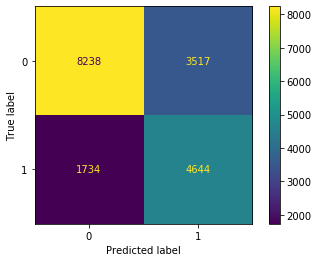

In [48]:
print('Best Balanced Random Forest Model to predict hospitalization: {}'.format(grid_brf_h.best_params_))
mlpipeline.confusion_metrics(grid_brf_h.best_estimator_, test, features, target2)

#### 2.2.3 Target: Severe Condition (i.e. Death or Hospitalized)

In [49]:
target3 = 'covid_grave'

In [50]:
#Train the model with severe condition
grid_brf_s = grid_brf
grid_brf_s.fit(train[features], train[target3])
#Store results in severe df
brf_results_severe = pd.DataFrame(grid_brf_s.cv_results_)[cols_to_keep]
brf_results_severe.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results_severe.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
11,entropy,15,15,1,0.721225,0.761005,0.587737,0.622519
5,gini,15,15,2,0.720882,0.762634,0.586606,0.623483
9,entropy,10,15,3,0.720194,0.734438,0.582051,0.594119
8,entropy,10,10,4,0.719965,0.735113,0.582683,0.595234
10,entropy,15,10,5,0.719889,0.763678,0.587344,0.626504
4,gini,15,10,6,0.719583,0.765698,0.587721,0.628709
2,gini,10,10,7,0.718858,0.735737,0.582096,0.596369
3,gini,10,15,8,0.718437,0.733899,0.582566,0.595937
7,entropy,5,15,9,0.715803,0.717983,0.572061,0.574077
6,entropy,5,10,10,0.715115,0.717737,0.572083,0.574249


Best Balanced Random Forest Model to predict severe condition : {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 15}
Model's Accuracy on test data: 0.72
Model's Precision on test data: 0.59
Model's Recall on test data: 0.73
Model's F1 Score: 0.652


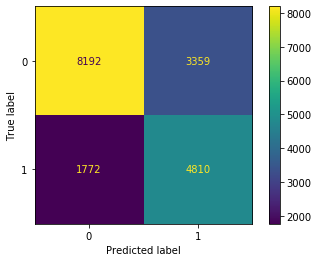

In [51]:
print('Best Balanced Random Forest Model to predict severe condition : {}'.format(grid_brf_s.best_params_))
mlpipeline.confusion_metrics(grid_brf_s.best_estimator_, test, features, target3)

### 2.2 Weighted Random Forest Classifier

The regular RF classifier tends to be biased towards the majority class, so the weighted random forest places a heavier penalty on misclassifying the minority class (i.e. the minority class is given a larger weight). 
The weights are used in the tree induction procedure (the splits) and in the terminal nodes (class determined by weighted majority vote).

For more applied models for imbalanced data: [link](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

In [52]:
from sklearn.ensemble import RandomForestClassifier
params = {'criterion':['gini', 'entropy'], 'max_depth':[10, 15],'class_weight':['balanced', 'balanced_subsample'],
         'min_samples_split':[10, 15]}       
grid_wrf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), 
                          param_grid=params, 
                          cv=10,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')

#### 2.2.1 Target: Death

In [53]:
grid_wrf_d = grid_wrf
grid_wrf_d.fit(train[features],train[target].values.ravel())
wrf_results = pd.DataFrame(grid_wrf_d.cv_results_)

In [54]:
cols_to_keep = ['param_class_weight','param_criterion','param_max_depth', 'param_min_samples_split', 
                'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
wrf_results = wrf_results[cols_to_keep]
wrf_results.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
13,balanced_subsample,entropy,10,15,1,0.765892,0.813615,0.235312,0.250556
5,balanced,entropy,10,15,2,0.764761,0.815094,0.235471,0.250715
1,balanced,gini,10,15,3,0.764635,0.816378,0.235543,0.251679
9,balanced_subsample,gini,10,15,4,0.762625,0.815331,0.235830,0.252457
12,balanced_subsample,entropy,10,10,5,0.762249,0.815443,0.235164,0.251715
4,balanced,entropy,10,10,6,0.760492,0.813768,0.235931,0.252473
8,balanced_subsample,gini,10,10,7,0.760491,0.816350,0.236038,0.253637
0,balanced,gini,10,10,8,0.760240,0.816099,0.235801,0.253412
15,balanced_subsample,entropy,15,15,9,0.660388,0.828072,0.257256,0.320678
7,balanced,entropy,15,15,10,0.659007,0.828533,0.256351,0.321038


Best Weighted Random Forest Model to predict death: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.69
Model's Precision on test data: 0.23
Model's Recall on test data: 0.77
Model's F1 Score: 0.349


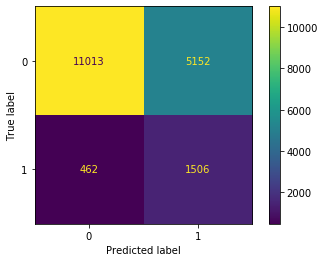

In [55]:
print('Best Weighted Random Forest Model to predict death: {}'.format(grid_wrf_d.best_params_))
mlpipeline.confusion_metrics(grid_wrf_d.best_estimator_, test, features, target)

#### 2.2.2 Target: Hospitalization

In [56]:
grid_wrf_h = grid_wrf
grid_wrf_h.fit(train[features],train[target2].values.ravel())
wrf_results_hos = pd.DataFrame(grid_wrf_h.cv_results_)[cols_to_keep]
wrf_results_hos.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results_hos.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
4,balanced,entropy,10,10,1,0.711347,0.730720,0.565835,0.581269
0,balanced,gini,10,10,2,0.710755,0.730558,0.566279,0.583419
12,balanced_subsample,entropy,10,10,3,0.710559,0.729726,0.565387,0.581407
8,balanced_subsample,gini,10,10,4,0.710401,0.730593,0.566197,0.583373
9,balanced_subsample,gini,10,15,5,0.710401,0.730111,0.565646,0.581871
13,balanced_subsample,entropy,10,15,6,0.710007,0.729432,0.565000,0.580333
1,balanced,gini,10,15,7,0.709888,0.730264,0.565758,0.582101
5,balanced,entropy,10,15,8,0.709888,0.729244,0.564879,0.580396
7,balanced,entropy,15,15,9,0.694163,0.752821,0.579310,0.631750
3,balanced,gini,15,15,10,0.692429,0.754656,0.579300,0.634516


Best Weighted Random Forest Model to predict Hospitalization: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Model's Accuracy on test data: 0.71
Model's Precision on test data: 0.57
Model's Recall on test data: 0.73
Model's F1 Score: 0.635


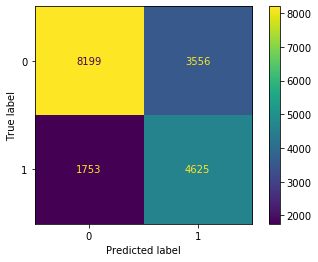

In [57]:
print('Best Weighted Random Forest Model to predict Hospitalization: {}'.format(grid_wrf_h.best_params_))
mlpipeline.confusion_metrics(grid_wrf_h.best_estimator_, test, features, target2)

#### 2.2.3 Target: Severe Condition (Death or Hospitalized)

In [58]:
grid_wrf_s = grid_wrf
grid_wrf_s.fit(train[features],train[target3].values.ravel())
wrf_results_sev = pd.DataFrame(grid_wrf_s.cv_results_)[cols_to_keep]
wrf_results_sev.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results_sev.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,balanced,entropy,10,15,1,0.713320,0.729262,0.585677,0.600304
13,balanced_subsample,entropy,10,15,2,0.713053,0.729164,0.585955,0.600549
12,balanced_subsample,entropy,10,10,3,0.712099,0.730114,0.585437,0.601130
1,balanced,gini,10,15,4,0.711793,0.730284,0.585962,0.601765
9,balanced_subsample,gini,10,15,5,0.711716,0.730271,0.585822,0.601708
8,balanced_subsample,gini,10,10,6,0.711259,0.730488,0.587018,0.603100
4,balanced,entropy,10,10,7,0.710914,0.729160,0.586843,0.602039
0,balanced,gini,10,10,8,0.710380,0.729868,0.586466,0.603241
15,balanced_subsample,entropy,15,15,9,0.698312,0.752739,0.598233,0.648726
7,balanced,entropy,15,15,10,0.697472,0.752926,0.598182,0.648797


Best Weighted Random Forest Model to predict Severe Condition: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.71
Model's Precision on test data: 0.58
Model's Recall on test data: 0.73
Model's F1 Score: 0.649


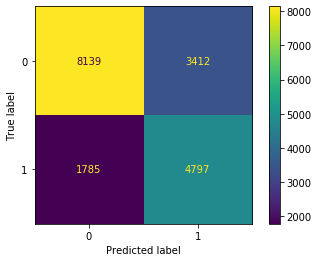

In [59]:
print('Best Weighted Random Forest Model to predict Severe Condition: {}'.format(grid_wrf_s.best_params_))
mlpipeline.confusion_metrics(grid_wrf_s.best_estimator_, test, features, target3)

### 2.3 Random Forest with SMOTE

Another technique to deal with imbalanced data is to apply Synthetic Minority Over-sampling Technique (SMOTE).
Unlike the over-sampling techniques that repeats the same information, new examples can be synthesized from the existing examples to boost the minority class.
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
pipeline = Pipeline([('sm',SMOTE(random_state=0)),
                     ('rf',RandomForestClassifier(random_state=0))])
params = dict(rf__criterion=['gini', 'entropy'],
                      rf__max_depth=[10,15],
             rf__min_samples_split= [10,25])    
grid_srf = GridSearchCV(estimator=pipeline, 
                          param_grid=params, 
                          cv=10,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')                 

#### 2.3.1 Target: Death

In [35]:
grid_srf.fit(train[features], train[target].values.ravel())
srf_results = pd.DataFrame(grid_srf.cv_results_)
cols_keep = ['param_rf__criterion', 'param_rf__max_depth', 'param_rf__min_samples_split', 
             'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
srf_results = srf_results[cols_keep]
srf_results.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
1,gini,10,25,1,0.378182,0.430140,0.293695,0.328828
0,gini,10,10,2,0.374033,0.438360,0.290929,0.334602
4,entropy,10,10,3,0.372280,0.425702,0.296027,0.335031
5,entropy,10,25,4,0.369642,0.419730,0.292967,0.326629
2,gini,15,10,5,0.284859,0.455120,0.297891,0.439335
3,gini,15,25,6,0.283728,0.416785,0.297480,0.411921
6,entropy,15,10,7,0.280464,0.436155,0.302405,0.437819
7,entropy,15,25,8,0.279456,0.403821,0.301931,0.412166


Best Random Forest Model(w/ SMOTE) to predict Death: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_split': 25}
Model's Accuracy on test data: 0.82
Model's Precision on test data: 0.28
Model's Recall on test data: 0.39
Model's F1 Score: 0.322


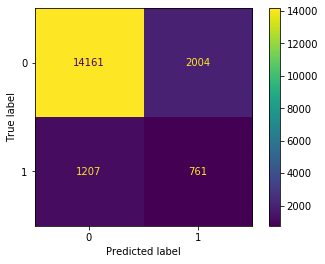

In [36]:
print('Best Random Forest Model(w/ SMOTE) to predict Death: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target)

#### 2.3.2 Target: Hospitalization

In [37]:
grid_srf.fit(train[features], train[target2].values.ravel())
srf_results_hos = pd.DataFrame(grid_srf.cv_results_)[cols_keep]
srf_results.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
1,gini,10,25,1,0.378182,0.430140,0.293695,0.328828
0,gini,10,10,2,0.374033,0.438360,0.290929,0.334602
4,entropy,10,10,3,0.372280,0.425702,0.296027,0.335031
5,entropy,10,25,4,0.369642,0.419730,0.292967,0.326629
2,gini,15,10,5,0.284859,0.455120,0.297891,0.439335
3,gini,15,25,6,0.283728,0.416785,0.297480,0.411921
6,entropy,15,10,7,0.280464,0.436155,0.302405,0.437819
7,entropy,15,25,8,0.279456,0.403821,0.301931,0.412166


Best Random Forest Model(w/ SMOTE) to predict Hospitalization: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_split': 10}
Model's Accuracy on test data: 0.72
Model's Precision on test data: 0.59
Model's Recall on test data: 0.66
Model's F1 Score: 0.626


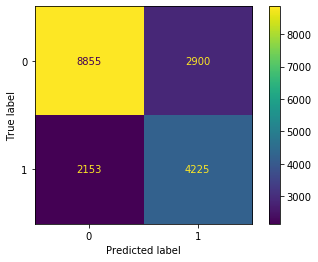

In [38]:
print('Best Random Forest Model(w/ SMOTE) to predict Hospitalization: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target2)

#### 2.3.3 Target: Severe Condition (i.e. Death or Hospitalization)

In [39]:
grid_srf.fit(train[features], train[target3].values.ravel())
srf_results_sev = pd.DataFrame(grid_srf.cv_results_)[cols_keep]
srf_results_sev.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,entropy,10,25,1,0.664133,0.679642,0.608720,0.623515
1,gini,10,25,2,0.663828,0.680453,0.607967,0.625204
4,entropy,10,10,3,0.663026,0.681340,0.608373,0.626136
0,gini,10,10,4,0.661804,0.681055,0.609204,0.628077
7,entropy,15,25,5,0.641564,0.692236,0.620097,0.668516
3,gini,15,25,6,0.640648,0.695049,0.618631,0.670077
2,gini,15,10,7,0.637096,0.705453,0.620032,0.687182
6,entropy,15,10,8,0.636715,0.701354,0.620826,0.683790


Best Random Forest Model(w/ SMOTE) to predict Severe Condition: {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__min_samples_split': 25}
Model's Accuracy on test data: 0.73
Model's Precision on test data: 0.61
Model's Recall on test data: 0.67
Model's F1 Score: 0.64


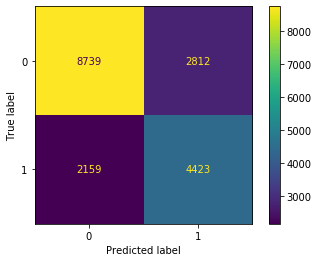

In [40]:
print('Best Random Forest Model(w/ SMOTE) to predict Severe Condition: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target3)

## 3. Feature Importance

From BalanceRF and Weighted RF models, we show the features' importances to predict deaths for COVID-19 patients.

### 3.1 Target Variable: Death

In [60]:
d = {'edad': 'age', 'diabetes': 'diabetes', 'epoc':'pulmonary disease', 'asma': 'asthma',
    'inmusupr': 'immunosuppression', 'hipertension': 'hypertension', 'cardiovascular':'cardiovascular', 
     'obesidad':'obesity','tabaquismo':'smoking','pobreza':'poverty',
     'medicos':'doctors', 'camas_hosp':'hospital beds', 'enfermeras':'nurses'}
features_en = [d[f] for f in features]

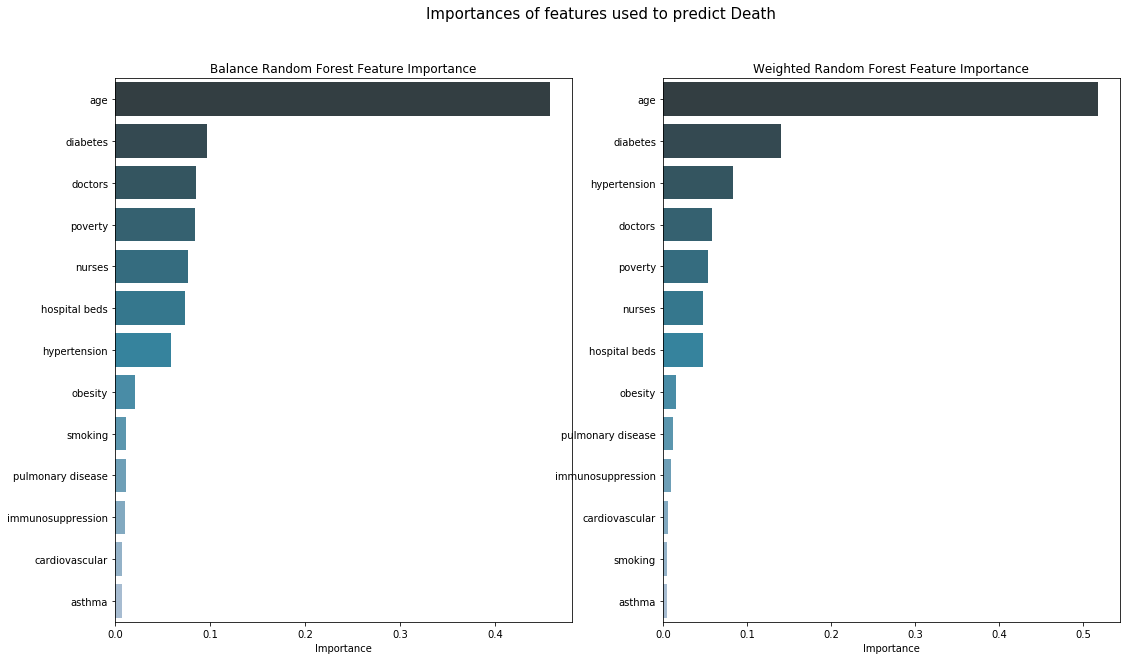

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_d.best_estimator_, ax1), (grid_wrf_d.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="PuBuGn_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Death', size=15)
plt.show()

### 3.2 Target Variable: Hospitalized

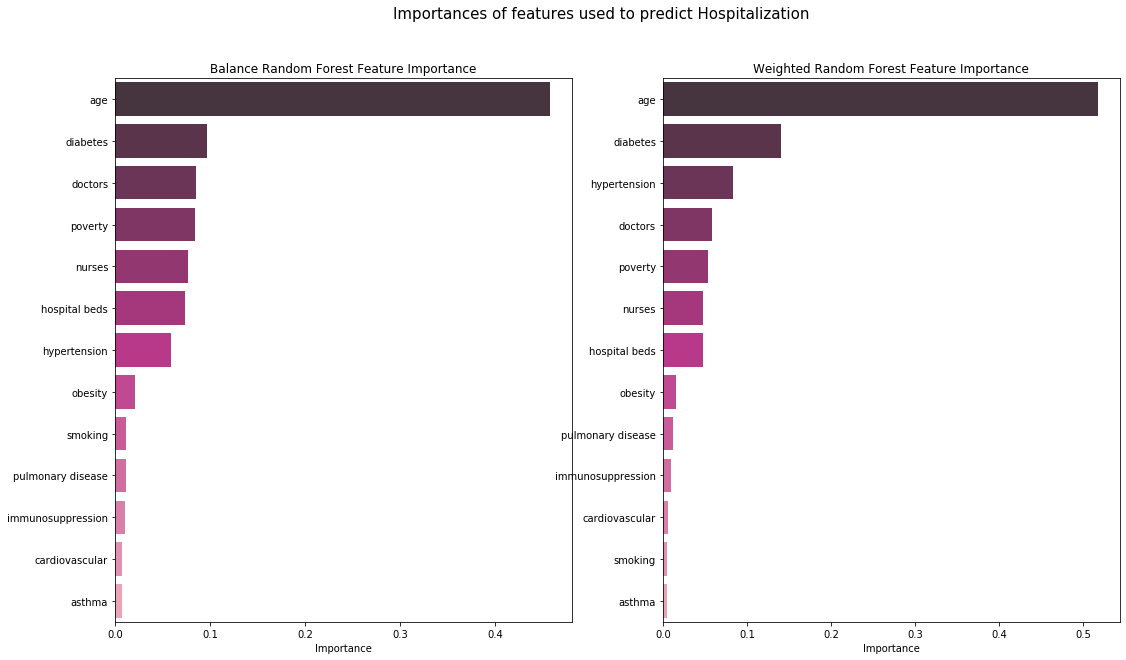

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_h.best_estimator_, ax1), (grid_wrf_h.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="RdPu_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Hospitalization', size=15)
plt.show()

### 3.3 Target Variable: Severe Condition

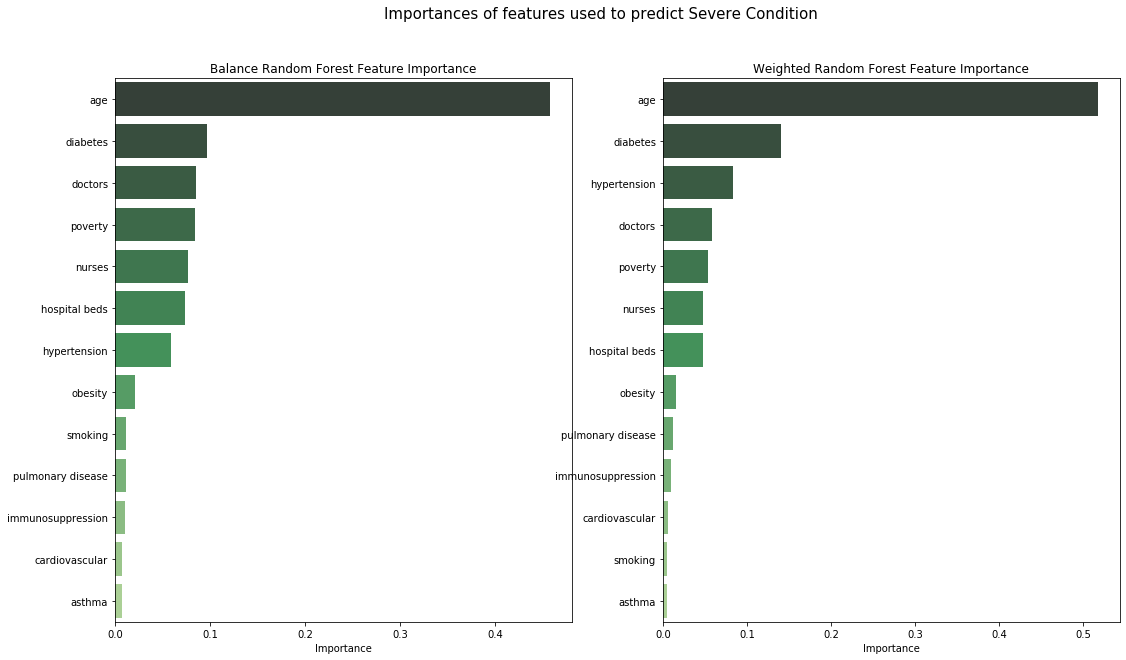

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_s.best_estimator_, ax1), (grid_wrf_s.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="YlGn_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Severe Condition', size=15)
plt.show()

In [77]:
print(grid_brf_d.best_estimator_.feature_importances_)
print(grid_brf_h.best_estimator_.feature_importances_)

[0.45757354 0.09631671 0.01144041 0.00733734 0.01029303 0.05838586
 0.00743452 0.02063851 0.01182145 0.08392213 0.08463886 0.07363822
 0.07655942]
[0.45757354 0.09631671 0.01144041 0.00733734 0.01029303 0.05838586
 0.00743452 0.02063851 0.01182145 0.08392213 0.08463886 0.07363822
 0.07655942]
